# Midterm 1, Assignment 2 - Gaetano Barresi

The chosen participant for my analysis was subject number 2.
First of all, let's try to load the dataset and plot the time series for one of the activities.

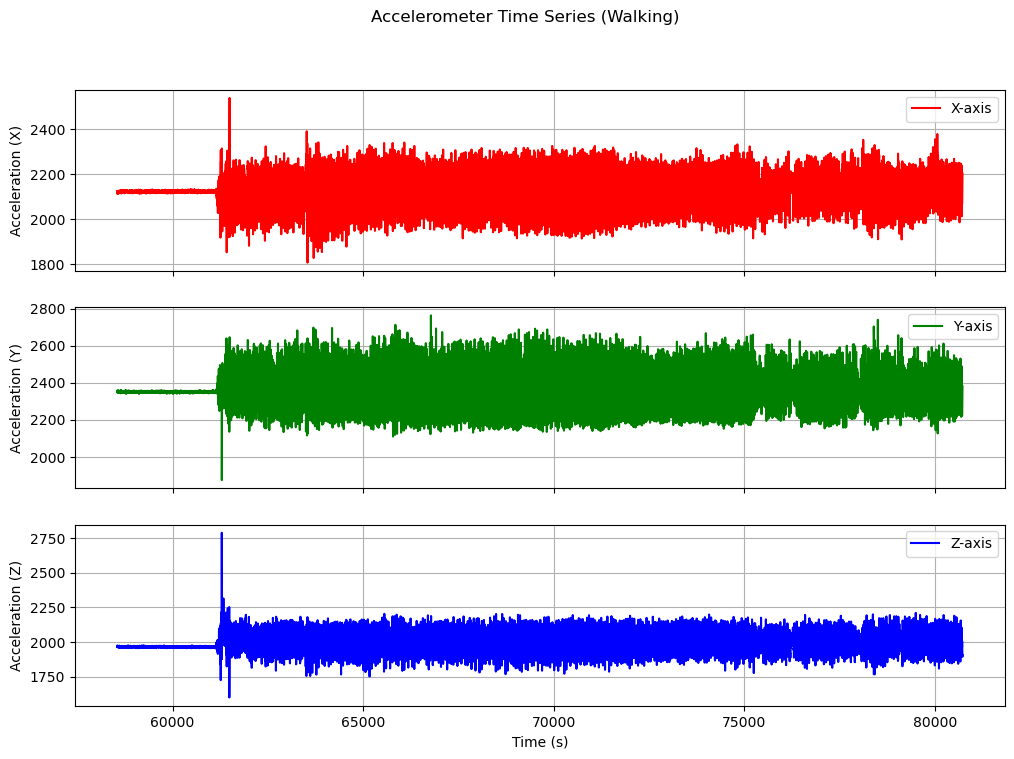

In [51]:
import pywt
import scipy
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def plot_time_series(data, activity):
    """
    Plots the 3 channels of the time series data.

    Parameters:
    data (pandas.DataFrame): The time series data.
    activity (str): The activity name to be used in the title.
    """
    # Create subplots
    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

    # Plot X-axis acceleration
    axes[0].plot(data['Time'], data['X'], color='r', label="X-axis")
    axes[0].set_ylabel("Acceleration (X)")
    axes[0].legend()
    axes[0].grid()

    # Plot Y-axis acceleration
    axes[1].plot(data['Time'], data['Y'], color='g', label="Y-axis")
    axes[1].set_ylabel("Acceleration (Y)")
    axes[1].legend()
    axes[1].grid()

    # Plot Z-axis acceleration
    axes[2].plot(data['Time'], data['Z'], color='b', label="Z-axis")
    axes[2].set_xlabel("Time (s)")
    axes[2].set_ylabel("Acceleration (Z)")
    axes[2].legend()
    axes[2].grid()

    # Title for the whole figure
    plt.suptitle(f"Accelerometer Time Series ({activity})")

    # Show plot
    plt.show()

#####################################################################à

# Load the data from the CSV file
column_names = ['Time', 'X', 'Y', 'Z', 'Label']
PARTICIPANT = 2
data = pd.read_csv(f'./dataset/{PARTICIPANT}.csv', header=None, names=column_names)

# plot the time series data for the activity of walking
walking = data[data['Label'] == 4]
plot_time_series(walking, "Walking")

The first things that we can see are:
- the accelerometer values are strange (I already know from README that they are uncalibrated);
- Time (s) presents the sample's number, not the time in seconds.

Let's plot the spectrogram of these signals. The wavelet family used to perform the CWT is the Mexican Hat.

ContinuousWavelet mexh
  Family name:    Mexican hat wavelet
  Short name:     mexh
  Symmetry:       symmetric
  DWT:            False
  CWT:            True
  Complex CWT:    False


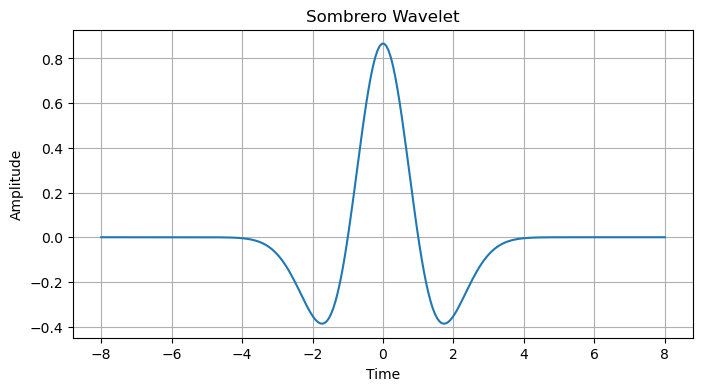

In [52]:
sombrero = pywt.ContinuousWavelet('mexh')
print(sombrero)

#plot the wavelet
plt.figure(figsize=(8, 4))
sombrero_wavelet = sombrero.wavefun()
plt.plot(sombrero_wavelet[1], sombrero_wavelet[0])
plt.title("Sombrero Wavelet")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

SPIEGA LA CWT E COME STO FACENDO SCALING, SPIEGA COSA È fc:


_min, f_max = freq_min, freq_max  # Min and max frequencies for CWT

    # Convert frequencies to scales
    scales = fc * fs / np.array([f_max, f_min])
    scales = np.linspace(scales[0], scales[1], num=100)  # 100 scales

    # Perform CWT for each signal
    coeff_x, freq_x = pywt.cwt(data['X'], scales, wavelet, sampling_period=1/fs)
    coeff_y, freq_y = pywt.cwt(data['Y'], scales, wavelet, sampling_period=1/fs)
    coeff_z, freq_z = pywt.cwt(data['Z'], scales, wavelet, sampling_period=1/fs)



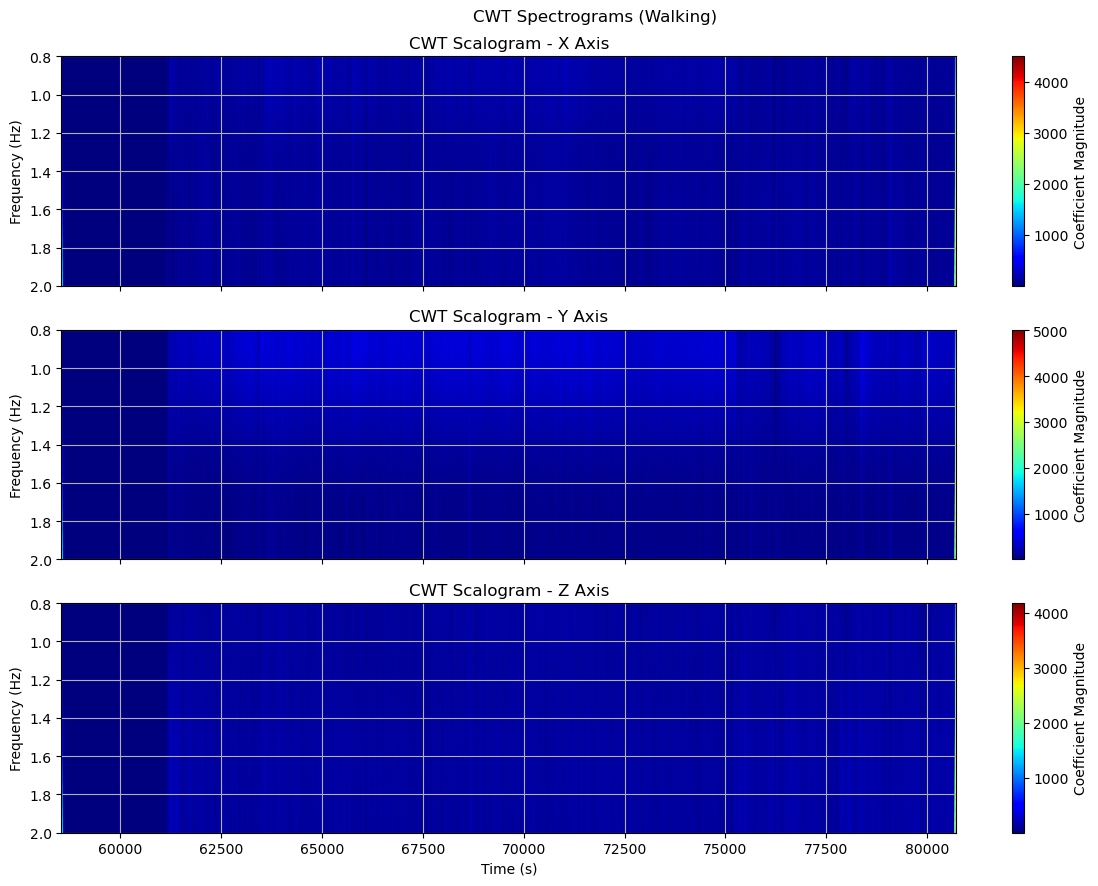

In [ ]:
def plot_cwt_spectrograms(data, wavelet, activity, fs=52, f_min=1, f_max=5, fc=0.25):
    # Convert frequencies to scales
    scales = fc * fs / np.array([f_max, f_min]) # fc = 0.25 for Mexican Hat wavelet
    scales = np.linspace(scales[0], scales[1], num=100)  # 100 scales

    # Perform CWT for each signal
    coeff_x, freq_x = pywt.cwt(data['X'], scales, wavelet, sampling_period=1/fs)
    coeff_y, freq_y = pywt.cwt(data['Y'], scales, wavelet, sampling_period=1/fs)
    coeff_z, freq_z = pywt.cwt(data['Z'], scales, wavelet, sampling_period=1/fs)

    # Plot CWT spectrograms (scalograms)
    fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

    # X-axis scalogram
    cax_x = axes[0].imshow(np.abs(coeff_x), aspect='auto', extent=[data['Time'].min(), data['Time'].max(), freq_x.max(), freq_x.min()], cmap='jet')
    axes[0].set_title("CWT Scalogram - X Axis")
    axes[0].set_ylabel("Frequency (Hz)")
    axes[0].grid()
    fig.colorbar(cax_x, ax=axes[0], orientation='vertical', label='Coefficient Magnitude')

    # Y-axis scalogram
    cax_y = axes[1].imshow(np.abs(coeff_y), aspect='auto', extent=[data['Time'].min(), data['Time'].max(), freq_y.max(), freq_y.min()], cmap='jet')
    axes[1].set_title("CWT Scalogram - Y Axis")
    axes[1].set_ylabel("Frequency (Hz)")
    axes[1].grid()
    fig.colorbar(cax_y, ax=axes[1], orientation='vertical', label='Coefficient Magnitude')

    # Z-axis scalogram
    cax_z = axes[2].imshow(np.abs(coeff_z), aspect='auto', extent=[data['Time'].min(), data['Time'].max(), freq_z.max(), freq_z.min()], cmap='jet')
    axes[2].set_title("CWT Scalogram - Z Axis")
    axes[2].set_ylabel("Frequency (Hz)")
    axes[2].set_xlabel("Time (s)")
    axes[2].grid()
    fig.colorbar(cax_z, ax=axes[2], orientation='vertical', label='Coefficient Magnitude')

    # Title for the whole figure
    plt.suptitle(f"CWT Spectrograms ({activity})")

    # Show the figure
    plt.tight_layout()
    plt.show()

#################################################################

plot_cwt_spectrograms(walking, sombrero, "Walking", f_min=0.8, f_max=2)

As we can see, is impossible to use the dataset as it is. First thing to do is to rescale the accelerometer's values and convert the time values. I know from the dataset's README file that the frequency sample (fs) used to acquire the data is 52hz. I can compute time in seconds through the following formula:


$$
t = \frac{N}{f_s}
$$

Where:
- \( t \) is the time,
- \( N \) is the number of samples,
- \( f_s \) is the sampling frequency.


For accelerometer's values, I'm using a StandardScaler. It standardize features by removing the mean and scaling to unit variance. The standard score of a sample x is calculated as:


$$
z = \frac{x - u}{s}
$$

Where:
- \( u \) is the mean,
- \( s \) is the standard deviation.

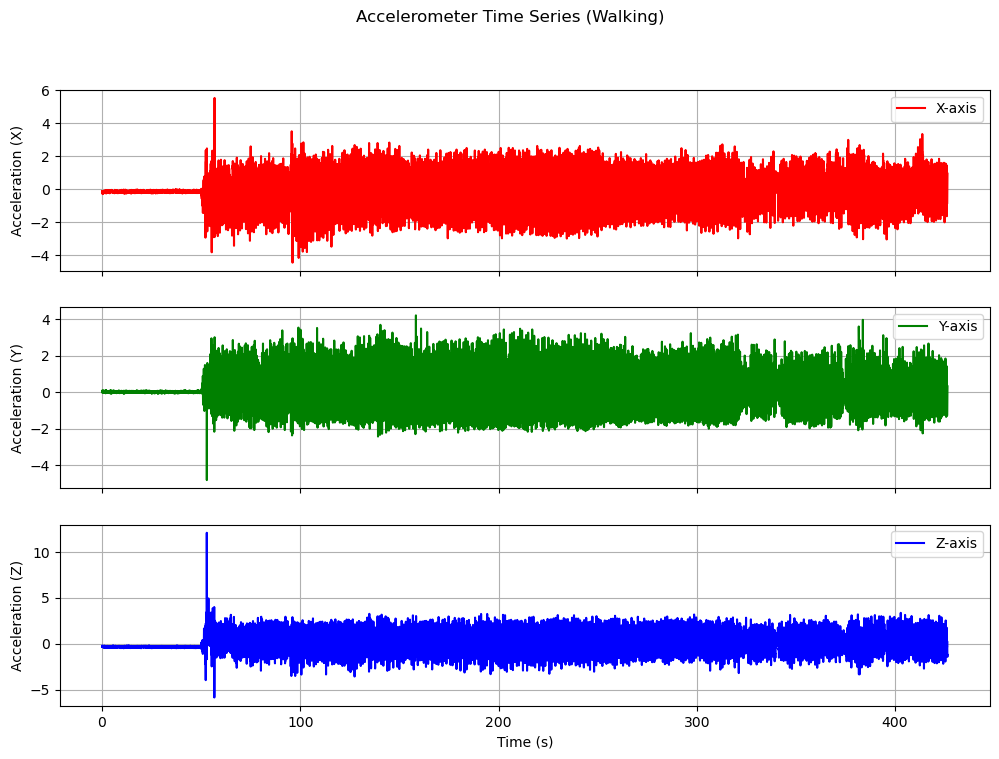

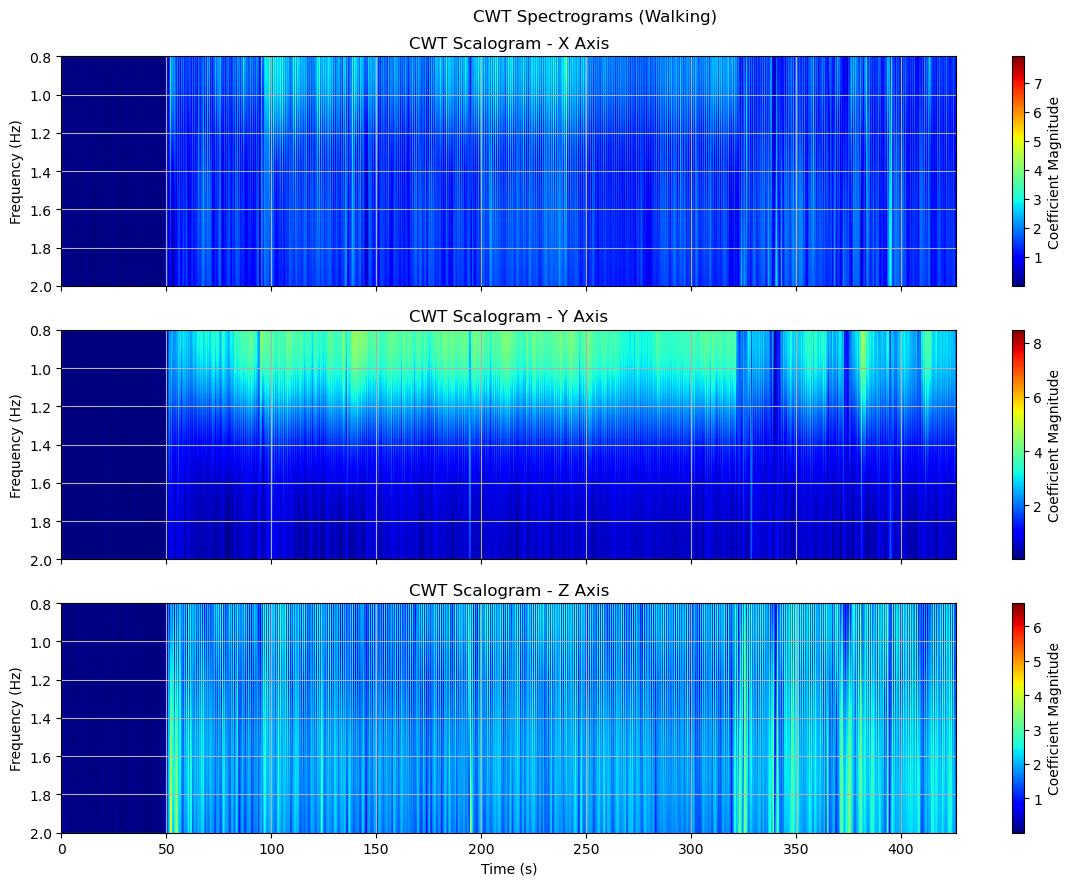

In [70]:
def low_pass_filter(data, threshold = 1): # the flter cut off frequencies over the threshold
    # Create the low pass butterworth filter that will filter at a frequency equal to the threshold
    b, a = scipy.signal.butter(8, threshold, 'low', fs=52)
    # Apply the filter to the data
    data['X'] = scipy.signal.filtfilt(b, a, data['X'])
    data['Y'] = scipy.signal.filtfilt(b, a, data['Y'])
    data['Z'] = scipy.signal.filtfilt(b, a, data['Z'])
    return data

def preprocess_data(data, fs=52, low_pass=False, low_pass_freq=1):
    new_data = data[['Time', 'X', 'Y', 'Z']].copy()

    if 'Sec' in data.columns:
        new_data['Time'] = data['Sec']
    else:
        # Compute time based on the sampling frequency of 52 Hz
        sample_numbers = np.arange(len(data))
        time = sample_numbers / fs  # Time in seconds
        new_data['Time'] = time

    # Standardize the data
    scaler = StandardScaler()
    new_data[['X', 'Y', 'Z']] = scaler.fit_transform(new_data[['X', 'Y', 'Z']])

    if low_pass:
        new_data = low_pass_filter(new_data, threshold=low_pass_freq)
    return new_data

###################################################

walking = data[data['Label'] == 4]
walking = preprocess_data(walking)
plot_time_series(walking, "Walking")
plot_cwt_spectrograms(walking, sombrero, "Walking", f_min=0.8, f_max=2)

For walking activity, we have a measurement of 400 seconds. We can already see that major activity is a low frequency, between 0.8hz and 1.2hz, so a slow pace walk. Let's pick just a 40 seconds signal in order to be more readable.

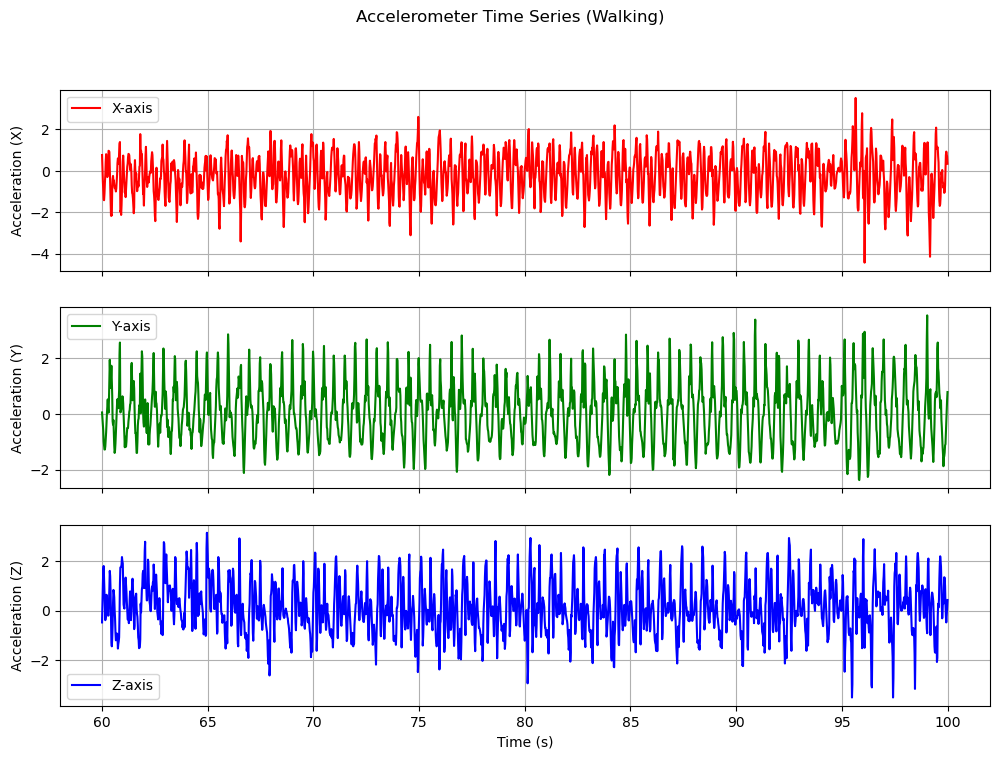

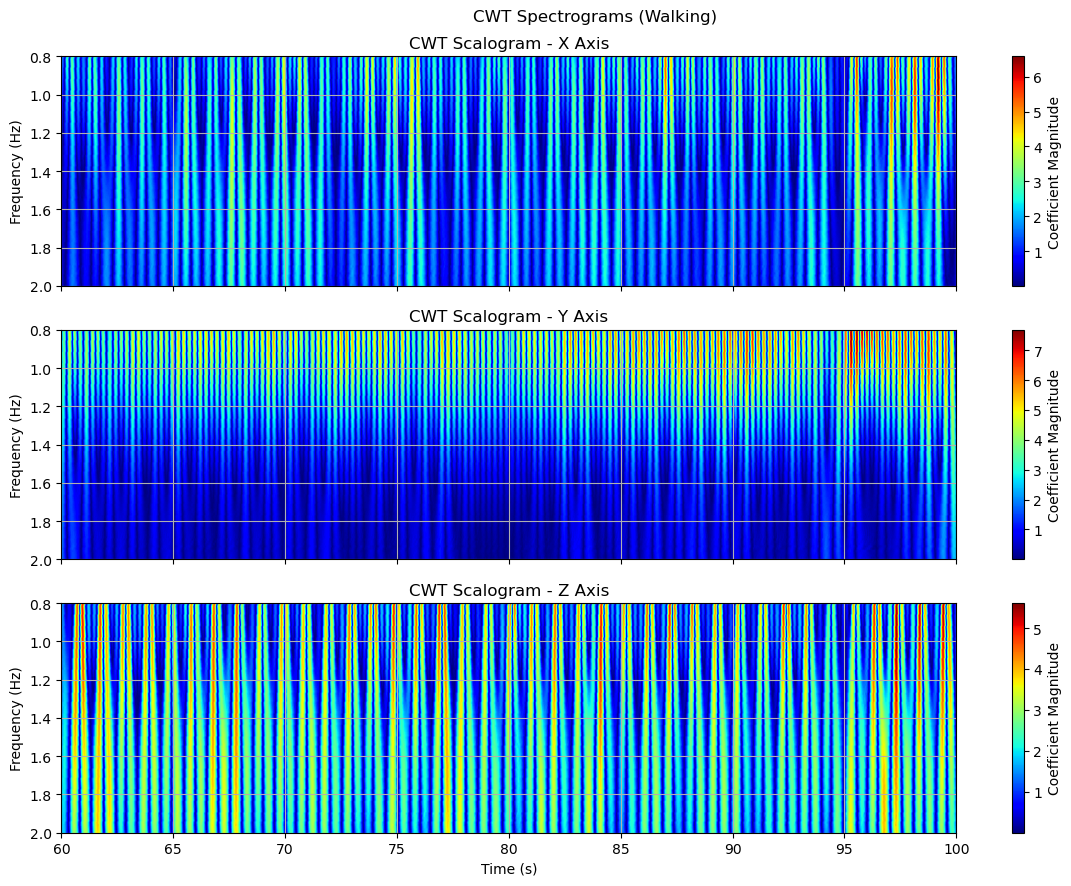

In [71]:
# take only the columns with Time greater than 60 and less than 80
walking = walking[(walking['Time'] >= 60) & (walking['Time'] <= 100)]
plot_time_series(walking, "Walking")
plot_cwt_spectrograms(walking, sombrero, "Walking", f_min=0.8, f_max=2)

We can see better the activity of walking: each step is represented by a peak in the spectrogram but it is a bit noisy. I will apply a lowpass filter to cutoff the frequency over 2hz and reduce the noise


SPIEGA COSA é IL FILTRO

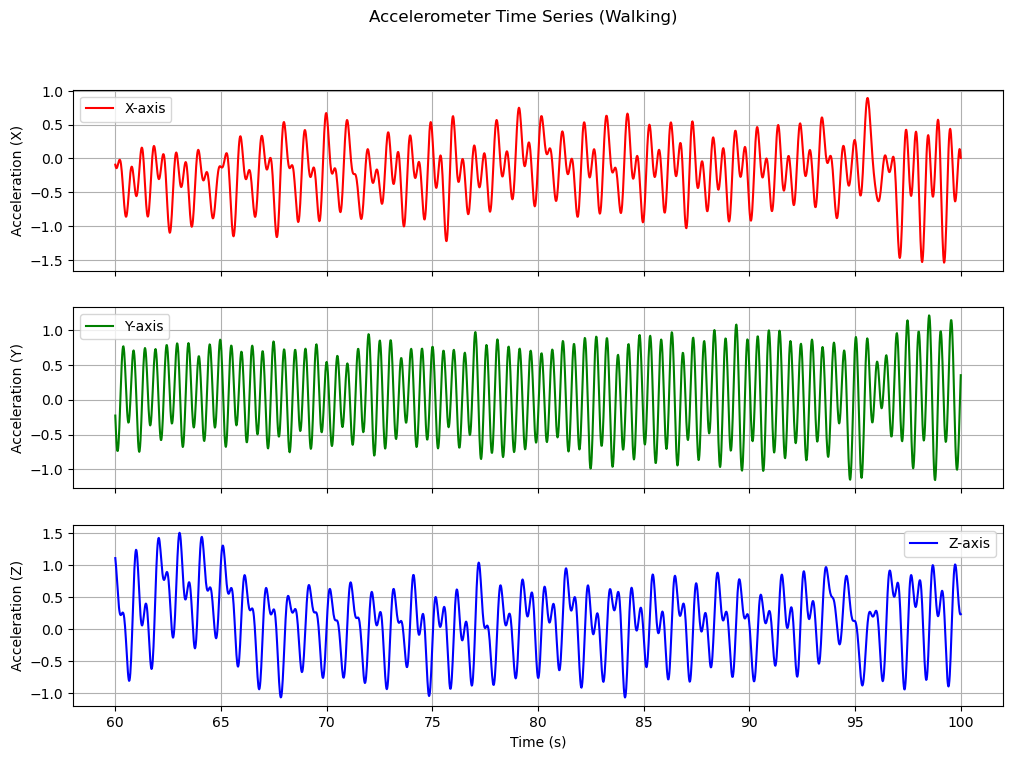

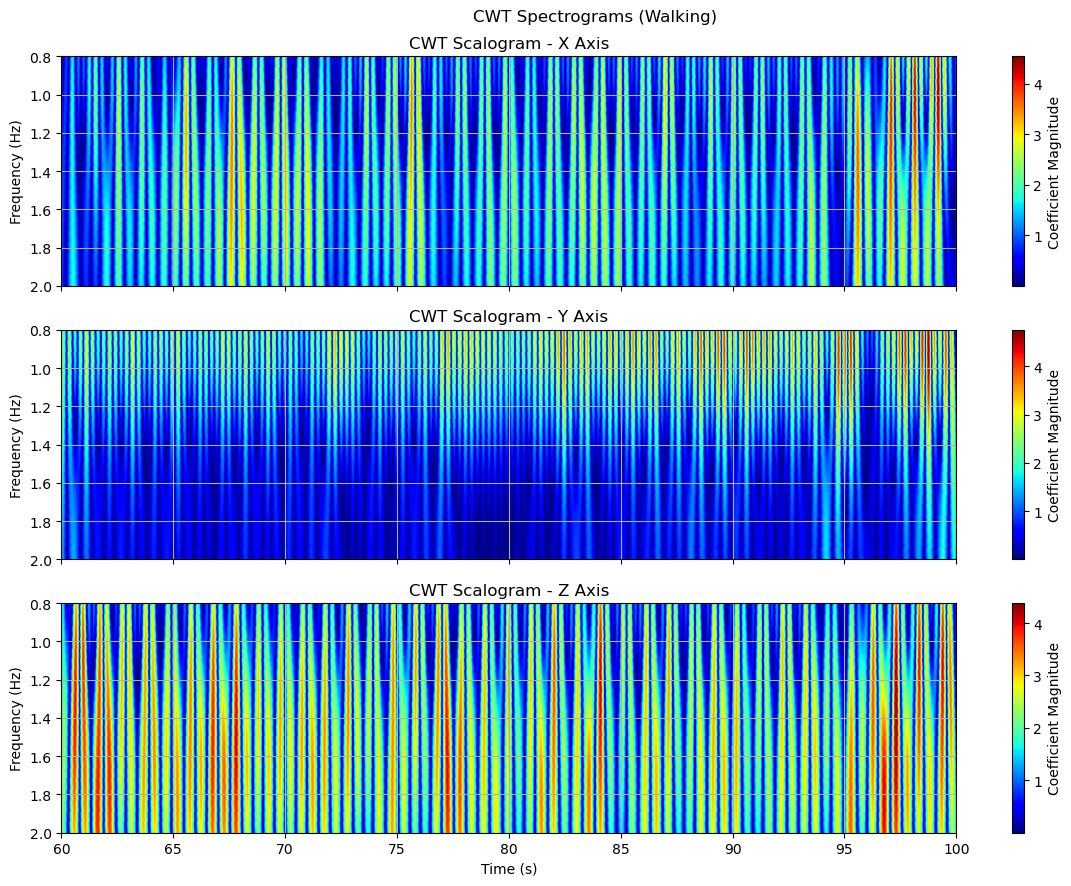

In [72]:
walking = data[data['Label'] == 4]
walking = preprocess_data(walking, low_pass=True, low_pass_freq=2)
walking = walking[(walking['Time'] >= 60) & (walking['Time'] <= 100)]
plot_time_series(walking, "Walking")
plot_cwt_spectrograms(walking, sombrero, "Walking", f_min=0.8, f_max=2)

Applying the lowpass filter enfatizes the pattern of a walk, expecially in the time series. Let's change activity: Going Up\Down Stairs.
The average frequency for this activity is between 1.5hz and 3hz.

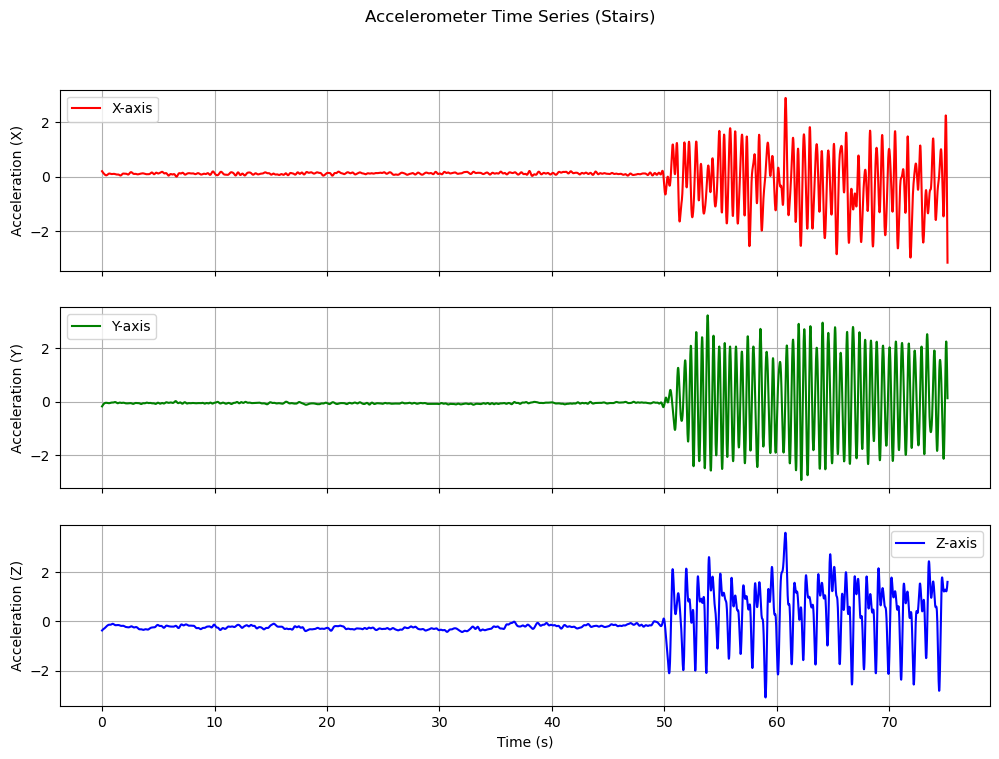

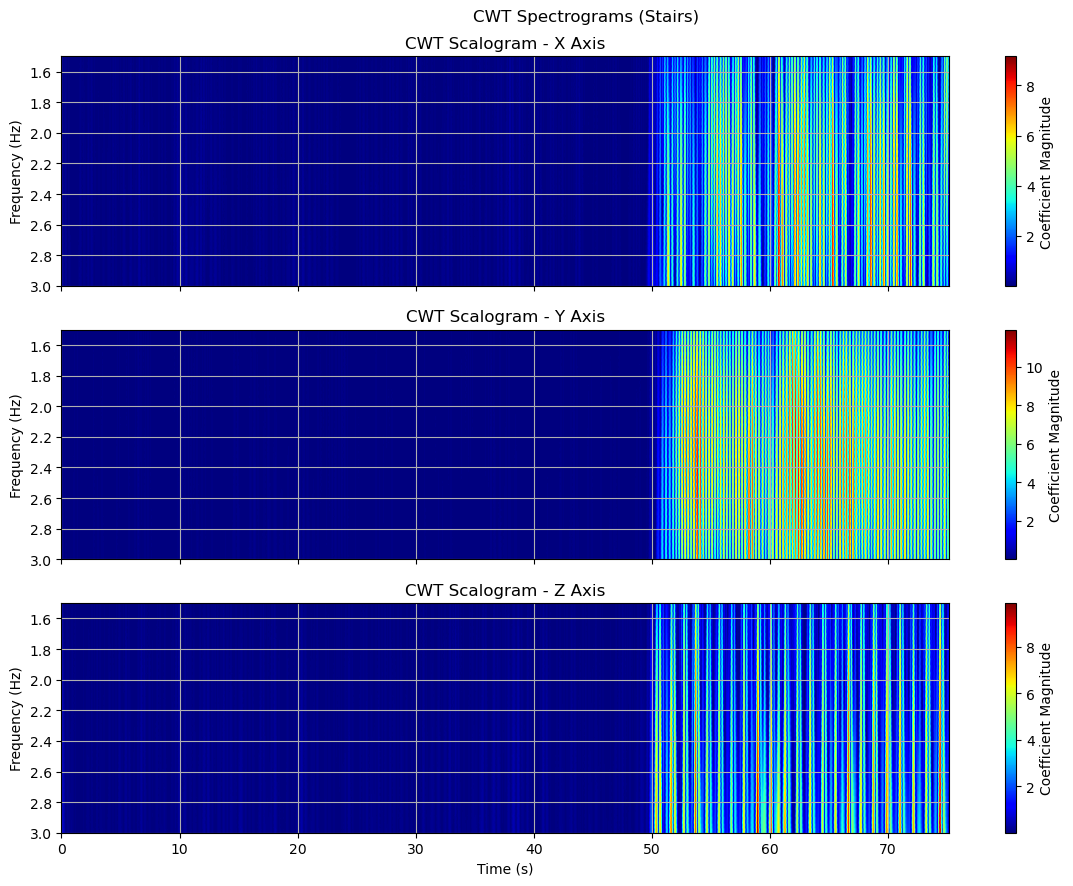

In [ ]:
stairs = data[data['Label'] == 5]
stairs = preprocess_data(stairs, low_pass=True, low_pass_freq=3)
plot_time_series(stairs, "Stairs")
plot_cwt_spectrograms(stairs, sombrero, "Stairs", f_min=1.5, f_max=3)